# Setup for Google Colab

## Downloading data from kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          10001        320  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           8006        254  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            482         23  1.0              
hasibalmuzdadid/global-air-pollution-dataset                    Global Air Pollu

In [7]:
!kaggle datasets download -d patrickaudriaz/tobacco3482jpg

100% 3.06G/3.07G [03:01<00:00, 20.9MB/s]
100% 3.07G/3.07G [03:01<00:00, 18.1MB/s]


In [8]:
!ls

kaggle.json  sample_data  tobacco3482jpg.zip


In [9]:
!unzip tobacco3482jpg.zip

Streaming output truncated to the last 5000 lines.
  inflating: Tobacco3482-jpg/Memo/2020268309.jpg  
  inflating: Tobacco3482-jpg/Memo/2020280503.jpg  
  inflating: Tobacco3482-jpg/Memo/2020340083.jpg  
  inflating: Tobacco3482-jpg/Memo/2021266006.jpg  
  inflating: Tobacco3482-jpg/Memo/2021514201_2021514203.jpg  
  inflating: Tobacco3482-jpg/Memo/2021548067.jpg  
  inflating: Tobacco3482-jpg/Memo/2021601265.jpg  
  inflating: Tobacco3482-jpg/Memo/2022142525.jpg  
  inflating: Tobacco3482-jpg/Memo/2022161599_2022161600.jpg  
  inflating: Tobacco3482-jpg/Memo/2022164378.jpg  
  inflating: Tobacco3482-jpg/Memo/2022165302_2022165304.jpg  
  inflating: Tobacco3482-jpg/Memo/2022177049_2022177054.jpg  
  inflating: Tobacco3482-jpg/Memo/2022180658_0659.jpg  
  inflating: Tobacco3482-jpg/Memo/2022181033.jpg  
  inflating: Tobacco3482-jpg/Memo/2022184512_2022184519.jpg  
  inflating: Tobacco3482-jpg/Memo/2022209162.jpg  
  inflating: Tobacco3482-jpg/Memo/2022210456_2022210457.jpg  
  inflating

In [10]:
!ls 

kaggle.json  sample_data  tobacco3482-jpg  Tobacco3482-jpg  tobacco3482jpg.zip


# Importing Libraries

In [21]:
import os
import random
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer

from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications import VGG16

# Hyper-parameters

In [22]:
img_size = 224
batch_size = 32
epochs = 30
train_size = 0.7
val_size = 0.15
test_size = 0.15
seed = 1
channels = 3
learning_rate = 0.00001

# Total classes and numebr of entries per classes

['./Tobacco3482-jpg/ADVE', './Tobacco3482-jpg/Memo', './Tobacco3482-jpg/Note', './Tobacco3482-jpg/Letter', './Tobacco3482-jpg/Report', './Tobacco3482-jpg/Scientific', './Tobacco3482-jpg/Resume', './Tobacco3482-jpg/Form', './Tobacco3482-jpg/Email', './Tobacco3482-jpg/News']
['ADVE', 'Memo', 'Note', 'Letter', 'Report', 'Scientific', 'Resume', 'Form', 'Email', 'News']
[231, 621, 202, 568, 266, 262, 121, 432, 600, 189]


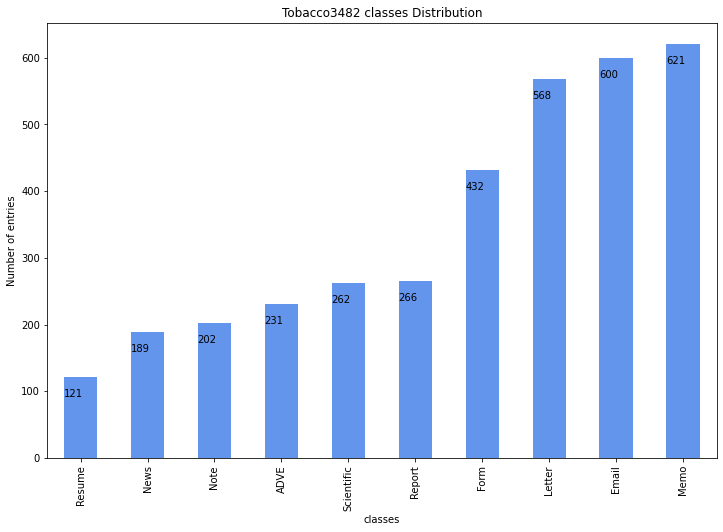

In [23]:
d = './Tobacco3482-jpg'
PATH = '../'

classes = (os.listdir(d))

paths = [os.path.join(d, o) for o in os.listdir(d) if os.path.isdir(os.path.join(d, o))]
print(paths)

nbEntries = []

for i in range(len(classes)):
    nbEntries.append(len(os.listdir(paths[i])))
    
print(classes)
print(nbEntries)

df = pd.DataFrame({'classes':classes, 'entries':nbEntries})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 classes Distribution')
ax.set_ylabel("Number of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-30))

# Get all images

In [24]:
total_set = []
total_labels = []

for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            path = root + '/' + file
            total_set.append(path)
            total_labels.append(root.split('/')[-1])
                     
def getClass(img):
    return img.split('/')[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

./Tobacco3482-jpg/ADVE/2042348217.jpg
GetClass :  ADVE
Label :  ADVE


# Plot data

./Tobacco3482-jpg/Letter/515792806+-2806.jpg


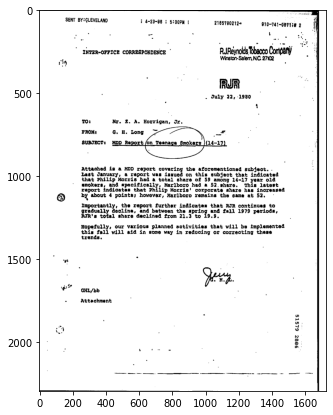

./Tobacco3482-jpg/Email/2078616645.jpg


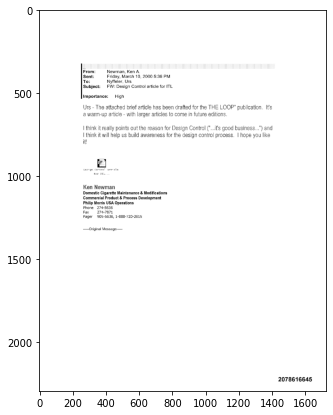

./Tobacco3482-jpg/Report/504841352.jpg


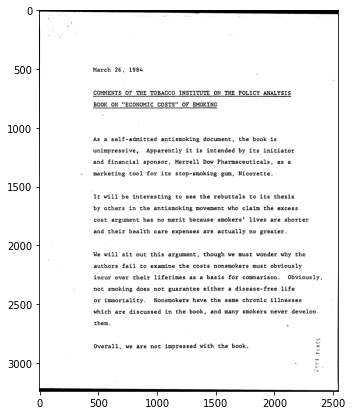

In [25]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = Image.open(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

# Train-val-test split

In [31]:
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)

for i in total_set[index: total_len]:
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])
print(test_set[200])
print(test_label[200])

./Tobacco3482-jpg/Email/2078790784.jpg
Email
./Tobacco3482-jpg/Letter/504789202_504789204.jpg
Letter


# Train-val-test classes distribution

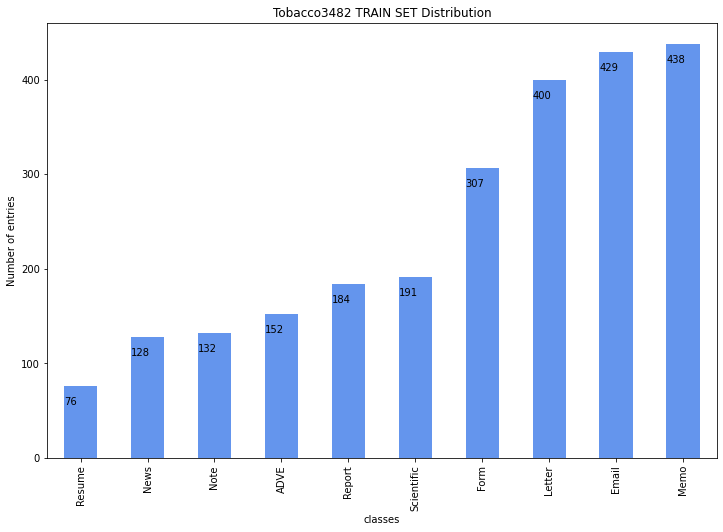

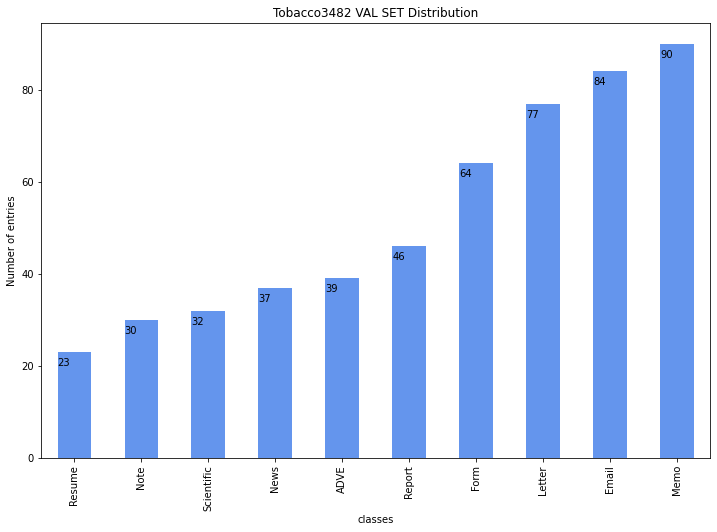

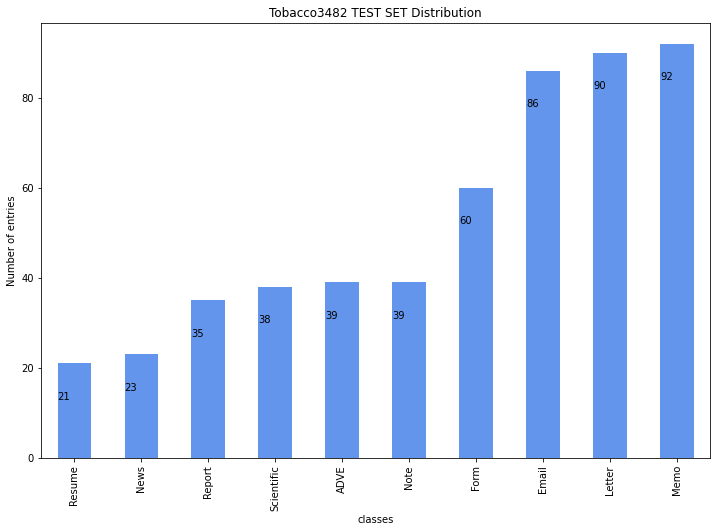

In [32]:
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TRAIN SET Distribution')
ax.set_ylabel("Number of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

    
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 VAL SET Distribution')
ax.set_ylabel("Number of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    

# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('Tobacco3482 TEST SET Distribution')
ax.set_ylabel("Number of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

# Preprocess data (resize, transform to ndarray and binarize)

In [33]:
def process_images(img_set) : 
    processed_img = []

    for i in tqdm(range(len(img_set))) :
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
data_train = process_images(train_set)
data_test = process_images(test_set)
data_val = process_images(val_set)

100%|██████████| 522/522 [00:19<00:00, 26.64it/s]


In [34]:
#Convert output labels into multiclass classification
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train = lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)

print(train_label[0])
print(y_train[0])
print(lb.classes_)

print(train_label[1])
print(y_train[1])
print(lb.classes_)

train images shape :  (2437, 224, 224, 3)
train labels shape :  (2437, 10)
test shape :  (523, 224, 224, 3)
(523, 10)
valdiation shape :  (522, 224, 224, 3)
(522, 10)
Letter
[0 0 0 1 0 0 0 0 0 0]
['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']
Email
[0 1 0 0 0 0 0 0 0 0]
['ADVE' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report' 'Resume'
 'Scientific']


# VGG16 model without training base layers

In [35]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
   layer.trainable = False
    
base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

# Adding custom layers

In [36]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu',  name='dense'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable layers : ', len(model.trainable_weights)/2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 10)                1290      
                                                                 
Total params: 17,927,370
Trainable params: 3,212,682
Non-trainable params: 14,714,688
_________________________________________________________________
Number of trainable layers :  2.0


In [37]:
model.compile(optimizer = Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
train_model = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/30
77/77 [==============================] - 26s 208ms/step - loss: 17.3503 - accuracy: 0.1362 - val_loss: 6.7414 - val_accuracy: 0.2931
Epoch 2/30
77/77 [==============================] - 13s 168ms/step - loss: 9.3581 - accuracy: 0.2716 - val_loss: 4.3722 - val_accuracy: 0.4004
Epoch 3/30
77/77 [==============================] - 13s 170ms/step - loss: 5.9413 - accuracy: 0.3410 - val_loss: 3.2288 - val_accuracy: 0.4502
Epoch 4/30
77/77 [==============================] - 13s 174ms/step - loss: 4.0758 - accuracy: 0.3956 - val_loss: 2.5584 - val_accuracy: 0.4828
Epoch 5/30
77/77 [==============================] - 13s 172ms/step - loss: 3.1810 - accuracy: 0.4144 - val_loss: 2.2040 - val_accuracy: 0.4962
Epoch 6/30
77/77 [==============================] - 13s 173ms/step - loss: 2.5333 - accuracy: 0.4296 - val_loss: 1.9943 - val_accuracy: 0.4904
Epoch 7/30
77/77 [==============================] - 13s 175ms/step - loss: 2.2470 - accuracy: 0.4436 - val_loss: 1.8392 - val_accuracy: 0.492

# Accuracy and loss of trained model

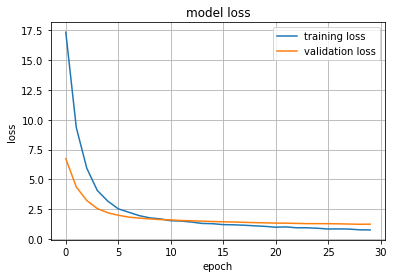

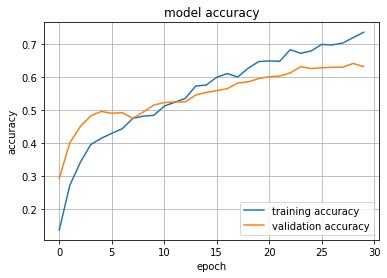

In [39]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

# Prediction on test set

In [40]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

17/17 [==============================] - 4s 221ms/step - loss: 1.2522 - accuracy: 0.6310
Test loss: 1.2521557807922363
Test accuracy: 0.6309751272201538


In [41]:
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

17/17 [==============================] - 2s 143ms/step
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Scientific    |   Real class :  Memo    |   Result :  False
Prediction :  Form    |   Real class :  Memo    |   Result :  False
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Report    |   Real class :  Scientific    |   Result :  False
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Scientific    |   Real class :  Scientific    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Email    |   Re

# VGG16 model with training base layers

In [42]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

# for layer in base_model.layers:
#    layer.trainable = False
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Adding custom layers

In [43]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu',  name='dense'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable layers : ', len(model.trainable_weights)/2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 10)                1290      
                                                                 
Total params: 17,927,370
Trainable params: 17,927,370
Non-trainable params: 0
_________________________________________________________________
Number of trainable layers :  15.0


In [44]:
model.compile(optimizer = Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [45]:
train_model = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/30
77/77 [==============================] - 41s 462ms/step - loss: 4.0158 - accuracy: 0.2089 - val_loss: 1.8826 - val_accuracy: 0.3793
Epoch 2/30
77/77 [==============================] - 34s 443ms/step - loss: 1.8317 - accuracy: 0.3751 - val_loss: 1.5978 - val_accuracy: 0.4464
Epoch 3/30
77/77 [==============================] - 34s 440ms/step - loss: 1.5518 - accuracy: 0.4637 - val_loss: 1.3265 - val_accuracy: 0.5690
Epoch 4/30
77/77 [==============================] - 34s 441ms/step - loss: 1.3111 - accuracy: 0.5691 - val_loss: 1.1173 - val_accuracy: 0.6341
Epoch 5/30
77/77 [==============================] - 34s 440ms/step - loss: 1.1247 - accuracy: 0.6311 - val_loss: 0.9267 - val_accuracy: 0.7126
Epoch 6/30
77/77 [==============================] - 34s 443ms/step - loss: 0.9625 - accuracy: 0.6779 - val_loss: 0.9459 - val_accuracy: 0.6916
Epoch 7/30
77/77 [==============================] - 34s 441ms/step - loss: 0.8991 - accuracy: 0.7103 - val_loss: 0.8153 - val_accuracy: 0.7433

# Accuracy and loss of trained model

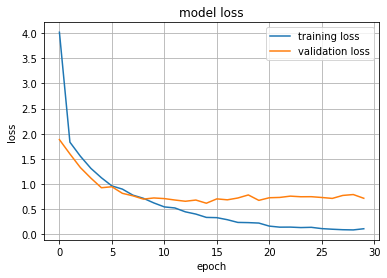

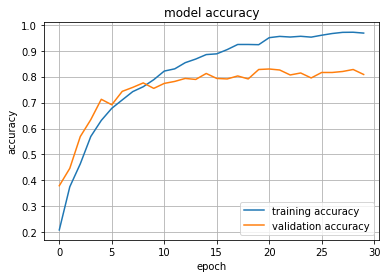

In [46]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

# Prediction on test set

In [47]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

17/17 [==============================] - 2s 142ms/step - loss: 0.6558 - accuracy: 0.8184
Test loss: 0.6557965278625488
Test accuracy: 0.8183556199073792


In [48]:
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions_list = predictions.tolist()
predicted_classes = lb.classes_

count_true = 0;
count_false = 0;

for i, prediction in enumerate(predictions_list):
    state = True
    if (predicted_classes[prediction] != test_label[i]) :
        state = False
        count_false += 1
    else :
        count_true += 1
    print("Prediction : ", predicted_classes[prediction], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

17/17 [==============================] - 2s 143ms/step
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Scientific    |   Real class :  Memo    |   Result :  False
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Scientific    |   Real class :  Scientific    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Letter    |   Real class :  Letter    |   Result :  True
Prediction :  Scientific    |   Real class :  Scientific    |   Result :  True
Prediction :  Email    |   Real class :  Email    |   Result :  True
Prediction :  Memo    |   Real class :  Memo    |   Result :  True
Prediction :  Email    |   